In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split



In [18]:
# Step 1: Load and preprocess the data


path = "./data/ABC.csv"
# Load the dataset
data = pd.read_csv(path)

print(data.head())

         Date      Low     Open    Volume     High     Close  Adjusted Close
0  04/04/1995  2.81250  2.93750  40387200  2.96875  2.953125        2.275675
1  05/04/1995  2.84375  2.90625  12236800  2.96875  2.843750        2.191389
2  06/04/1995  2.84375  2.84375   3776000  2.93750  2.890625        2.227511
3  07/04/1995  2.84375  2.90625   1920800  2.90625  2.843750        2.191389
4  10/04/1995  2.84375  2.84375   2047200  2.90625  2.875000        2.215471


In [19]:

# Convert 'Date' to datetime format and sort
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data = data.sort_values('Date')

# print(data.head())
print("=====================================")

# Select the feature (e.g., Adjusted Close price) for prediction and normalize
scaler = MinMaxScaler(feature_range=(0, 1))
data['Adjusted Close'] = scaler.fit_transform(data[['Adjusted Close']])

# print(data.head())
print("=====================================")


# Prepare sequences for LSTM: create X (input sequences) and y (target)
sequence_length = 1  # This is the length of the sequence used as input to predict the next value
X, y = [], []
for i in range(len(data) - sequence_length):
    X.append(data['Adjusted Close'].values[i:i+sequence_length])
    y.append(data['Adjusted Close'].values[i+sequence_length])

X, y = np.array(X), np.array(y)
X = np.expand_dims(X, axis=2)  # LSTM expects input in 3D [samples, time steps, features]

# print(X.shape)
# print(y.shape)

print("=====================================") 


# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders for batching
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)







# Print shapes of train and test sets
print(f"Train data shape: {train_data.tensors[0].shape}, {train_data.tensors[1].shape}")
print(f"Test data shape: {test_data.tensors[0].shape}, {test_data.tensors[1].shape}")



Train data shape: torch.Size([5577, 1, 1]), torch.Size([5577])
Test data shape: torch.Size([1395, 1, 1]), torch.Size([1395])


In [20]:
# Step 2: Define the LSTM model
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM output
        out = self.fc(out[:, -1, :])  # Fully connected layer to get the final output
        return out


In [21]:
# Step 3: Train the model 

epoch_track = []
loss_track = []

# Initialize model, loss criterion, optimizer
model = StockPriceLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track the best loss and corresponding model state
best_loss = float('inf')
best_model_state = None

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0  # Accumulate loss for the epoch
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  # Add batch loss to epoch loss





    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)

    # Save the model if the loss is lower than the best loss so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # Save the current state of the model
        torch.save(best_model_state, 'best_model.pth')  # Optionally save to disk

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.8f}, Best Loss: {best_loss:.8f}')
        
        epoch_track.append(epoch+1)
        loss_track.append(epoch_loss)

print("Training complete. Best model saved as 'best_model.pth'.")

Epoch 10/100, Loss: 0.00000959, Best Loss: 0.00000947
Epoch 20/100, Loss: 0.00001022, Best Loss: 0.00000921
Epoch 30/100, Loss: 0.00001133, Best Loss: 0.00000921
Epoch 40/100, Loss: 0.00001174, Best Loss: 0.00000921
Epoch 50/100, Loss: 0.00000969, Best Loss: 0.00000921
Epoch 60/100, Loss: 0.00001040, Best Loss: 0.00000921
Epoch 70/100, Loss: 0.00001159, Best Loss: 0.00000921
Epoch 80/100, Loss: 0.00001041, Best Loss: 0.00000921
Epoch 90/100, Loss: 0.00000974, Best Loss: 0.00000921
Epoch 100/100, Loss: 0.00001092, Best Loss: 0.00000921
Training complete. Best model saved as 'best_model.pth'.


In [26]:
# Step 4: Evaluate the model

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# check the  MSE, RMSE, MAE and MAPE
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        predictions.extend(outputs.squeeze().tolist())

# Average test loss
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.8f}')

# Inverse transform the predictions and actuals
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
actuals = scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).squeeze()

# Calculate the Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, and Mean Absolute Percentage Error
mse = np.mean((predictions - actuals) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - actuals))
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print(f' MSE: {mse:.8f}\n RMSE: {rmse:.8f}\n MAE: {mae:.8f}\n MAPE: {mape:.8f}%')



Test Loss: 0.00015010
 MSE: 4.28733473
 RMSE: 2.07058802
 MAE: 1.51575218
 MAPE: 1.53990751%


C:\Users\user\AppData\Local\Temp\ipykernel_27528\1006386306.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


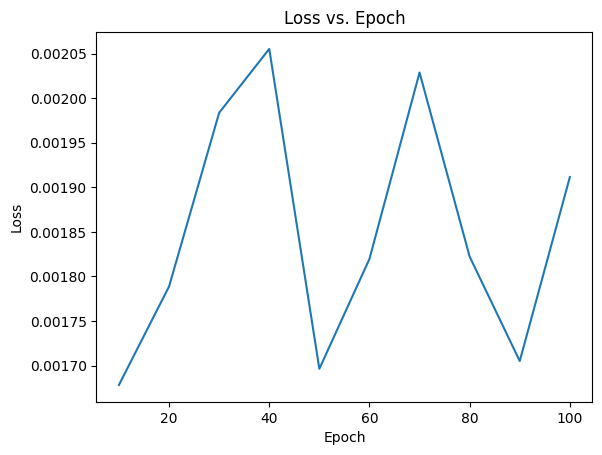

In [23]:
# plot the loss as y axis and epoch as x axis
import matplotlib.pyplot as plt
plt.plot(epoch_track, loss_track)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

# validate the model

C:\Users\user\AppData\Local\Temp\ipykernel_27528\2304636376.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Mean Squared Error: 4.287334734711157


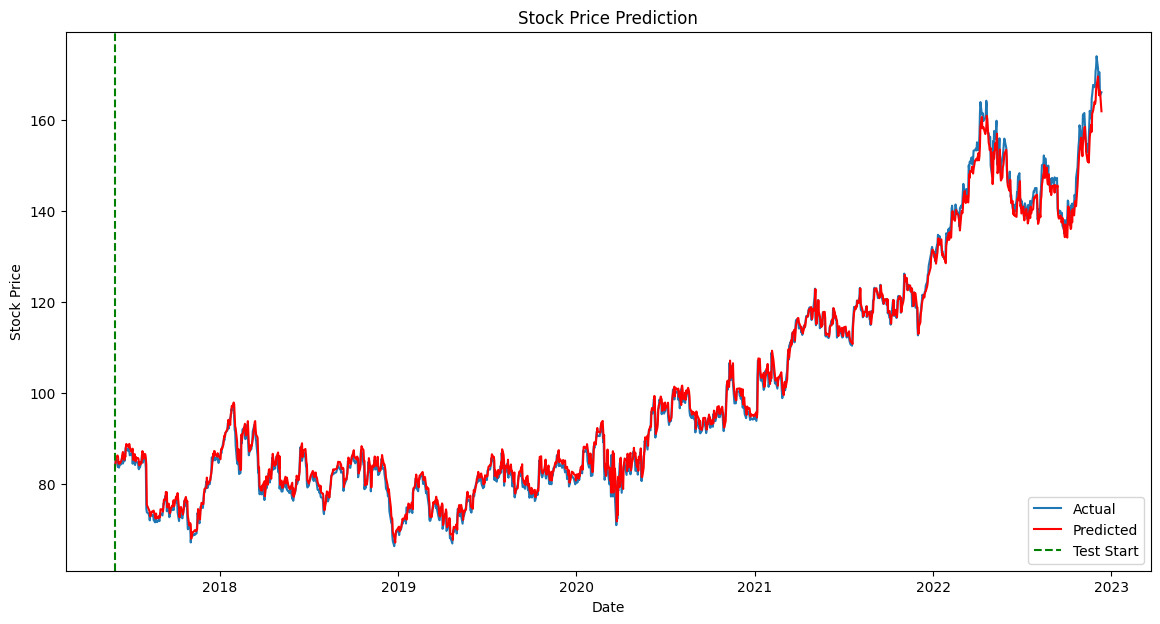

In [24]:
# step 4 validate the model using the best_model.pth
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


# Make predictions on the test set
model.eval()
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())

# Inverse transform the predictions
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual values
actual = y_test.numpy().reshape(-1, 1)
actual = scaler.inverse_transform(actual)

# Calculate the Mean Squared Error
mse = np.mean(np.square(predictions - actual))
print(f'Mean Squared Error: {mse}')




# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
# x axis is the date
plt.plot(data['Date'][-len(actual):], actual, label='Actual')
# red colour line is the predicted value for from test data
plt.plot(data['Date'][-len(predictions):], predictions, label='Predicted', color='red')



# Add a vertical line to mark the start of the test data
test_start_date = data['Date'].iloc[-len(actual)]  # Get the date corresponding to the start of test data
plt.axvline(x=test_start_date, color='green', linestyle='--', label='Test Start')



plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# For better understanding what the LSTM cell looks like 


# Try using PyTorch + Lightning 


In [29]:
import torch # torch will allow us to create tensors.
import torch.nn as nn # torch.nn allows us to create a neural network.
import torch.nn.functional as F # nn.functional give us access to the activation and loss functions.
from torch.optim import Adam # optim contains many optimizers. This time we're using Adam

import lightning as L # lightning has tons of cool tools that make neural networks easier
from torch.utils.data import TensorDataset, DataLoader # these are needed for the training data



In [30]:
## Here we are implementing an LSTM network by hand...
class LSTMbyHand(L.LightningModule):

    def __init__(self):
        
        super().__init__()

        ## The first thing we do is set the seed for the random number generorator.
        ## This ensures that when someone creates a model from this class, that model
        ## will start off with the exact same random numbers as I started out with when
        ## I created this demo. At least, I hope that is what happens!!! :)
        L.seed_everything(seed=42)
        
        ###################
        ##
        ## Initialize the tensors for the LSTM
        ##
        ###################
        
        ## NOTE: nn.LSTM() uses random values from a uniform distribution to initialize the tensors
        ## Here we can do it 2 different ways 1) Normal Distribution and 2) Uniform Distribution
        ## We'll start with the Normal Distribtion...
        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)        
        
        ## NOTE: In this case, I'm only using the normal distribution for the Weights.
        ## All Biases are initialized to 0.
        ##
        ## These are the Weights and Biases in the first stage, which determines what percentage
        ## of the long-term memory the LSTM unit will remember.
        self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        
# ================================================================================================================


        ## input gate        
        self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)


# ================================================================================================================

        ## forget gate
        ## These are the Weights and Biases in the second stage, which determines the new long-term memory.
        self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
# ================================================================================================================

        ## output gate
        ## These are the Weights and Biases in the third stage, which determines the
        ## new short-term memory and what percentage will be sent to the output.
        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        





        
        ## We can also initialize all Weights and Biases using a uniform distribution. This is
        ## how nn.LSTM() does it.
#         self.wlr1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wlr2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.blr1 = nn.Parameter(torch.rand(1), requires_grad=True)

#         self.wpr1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wpr2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.bpr1 = nn.Parameter(torch.rand(1), requires_grad=True)

#         self.wp1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wp2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.bp1 = nn.Parameter(torch.rand(1), requires_grad=True)
        
#         self.wo1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wo2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.bo1 = nn.Parameter(torch.rand(1), requires_grad=True)
        
        
    def lstm_unit(self, input_value, long_memory, short_memory):
        ## lstm_unit does the math for a single LSTM unit.
        
        ## NOTES:
        ## long term memory is also called "cell state"
        ## short term memory is also called "hidden state"
        
        ## 1) The first stage determines what percent of the current long-term memory
        ##    should be remembered
        long_remember_percent = torch.sigmoid((short_memory * self.wlr1) + 
                                              (input_value * self.wlr2) + 
                                              self.blr1)
        


        
        ## 2) The second stage creates a new, potential long-term memory and determines what
        ##    percentage of that to add to the current long-term memory
        potential_remember_percent = torch.sigmoid((short_memory * self.wpr1) + 
                                                   (input_value * self.wpr2) + 
                                                   self.bpr1)
        potential_memory = torch.tanh((short_memory * self.wp1) + 
                                      (input_value * self.wp2) + 
                                      self.bp1)
        
        ## Once we have gone through the first two stages, we can update the long-term memory
        updated_long_memory = ((long_memory * long_remember_percent) + 
                       (potential_remember_percent * potential_memory))
        


        

        ## 3) The third stage creates a new, potential short-term memory and determines what
        ##    percentage of that should be remembered and used as output.
        output_percent = torch.sigmoid((short_memory * self.wo1) + 
                                       (input_value * self.wo2) + 
                                       self.bo1)         
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent
        
        ## Finally, we return the updated long and short-term memories
        return([updated_long_memory, updated_short_memory])
        
    
    def forward(self, input): 
        ## forward() unrolls the LSTM for the training data by calling lstm_unit() for each day of training data 
        ## that we have. forward() also keeps track of the long and short-term memories after each day and returns
        ## the final short-term memory, which is the 'output' of the LSTM.
        
        long_memory = 0
        short_memory = 0
        for day in input:
            long_memory, short_memory = self.lstm_unit(day, long_memory, short_memory)
        return short_memory
        
        
    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        # return Adam(self.parameters(), lr=0.1) # NOTE: Setting the learning rate to 0.1 trains way faster than
                                                 # using the default learning rate, lr=0.001, which requires a lot more 
                                                 # training. However, if we use the default value, we get 
                                                 # the exact same Weights and Biases that I used in
                                                 # the LSTM Clearly Explained StatQuest video. So we'll use the
                                                 # default value.
        return Adam(self.parameters(), lr=0.001)

    
    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        input_i, label_i = batch # collect input
        output_i = self.forward(input_i) # run input through the neural network
        loss = torch.mean((output_i - label_i)**2) ## loss = squared residual
        
        self.log("train_loss", loss)
        return loss

In [31]:
data = pd.read_csv('data/ABC.csv') # load the data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y') # convert the date to a datetime object
data = data.sort_values('Date') # sort the data by date
data['Adjusted Close'] = scaler.fit_transform(data[['Adjusted Close']]) # normalize the data

sequence_length = 1 # the length of the sequence we're using to predict the next value
X, y = [], [] # create empty lists to store the sequences and targets
for i in range(len(data) - sequence_length): # loop through the data
    X.append(data['Adjusted Close'].values[i:i+sequence_length]) # add the sequence
    y.append(data['Adjusted Close'].values[i+sequence_length]) # add the target



X, y = np.array(X), np.array(y) # convert the lists to numpy arrays
X = np.expand_dims(X, axis=2) # add an extra dimension to the input data



X_train = torch.tensor(X, dtype=torch.float32) # convert the input data to a PyTorch tensor
y_train = torch.tensor(y, dtype=torch.float32) # convert the target data to a PyTorch tensor

train_data = TensorDataset(X_train, y_train) # create a dataset from the input and target data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # create a DataLoader for batching




In [32]:

model = LSTMbyHand() 


print("Before optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)

Seed set to 42


Before optimization, the parameters are...
wlr1 tensor(0.3367)
wlr2 tensor(0.1288)
blr1 tensor(0.)
wpr1 tensor(0.2345)
wpr2 tensor(0.2303)
bpr1 tensor(0.)
wp1 tensor(-1.1229)
wp2 tensor(-0.1863)
bp1 tensor(0.)
wo1 tensor(2.2082)
wo2 tensor(-0.6380)
bo1 tensor(0.)


In [13]:
from pytorch_lightning import Trainer

# Instantiate the model
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, train_dataloaders = train_loader)




    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 12     | n/a 
---------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
print("After optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)

After optimization, the parameters are...
wlr1 tensor(0.3367)
wlr2 tensor(0.1288)
blr1 tensor(0.)
wpr1 tensor(0.2345)
wpr2 tensor(0.2303)
bpr1 tensor(0.)
wp1 tensor(-1.1229)
wp2 tensor(-0.1863)
bp1 tensor(0.)
wo1 tensor(2.2082)
wo2 tensor(-0.6380)
bo1 tensor(0.)


In [36]:



model.eval()
with torch.no_grad():

    
    test_seq = torch.tensor(X[-1:], dtype=torch.float32)  # Get the last sequence in the dataset
    # print("test_seq: ", test_seq)
    # original_value = scaler.inverse_transform(test_seq.reshape(-1, 1))  # Reshape to match scaler input
    # print("Original value: ", original_value)

    prediction = model(test_seq).item()  # Get the prediction
    prediction = scaler.inverse_transform([[prediction]])  # Un-normalize
    print("Predicted Adjusted Close price for next day:", prediction[0][0])

    # print the true value of the next day
    print("True Adjusted Close price for next day:", scaler.inverse_transform(y[-1].reshape(-1, 1))[0][0])

    # check the MSE, RMSE, MAE and MAPE
    mse = np.mean((prediction - scaler.inverse_transform(y[-1].reshape(-1, 1))) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(prediction - scaler.inverse_transform(y[-1].reshape(-1, 1))))
    mape = np.mean(np.abs((scaler.inverse_transform(y[-1].reshape(-1, 1)) - prediction) / scaler.inverse_transform(y[-1].reshape(-1, 1)))) * 100

    print(f'MSE: {mse:.8f}\nRMSE: {rmse:.8f}\nMAE: {mae:.8f}\nMAPE: {mape:.8f}%')

    

    


Predicted Adjusted Close price for next day: -3.9528244056679425
True Adjusted Close price for next day: 166.0599976
MSE: 28904.35964633
RMSE: 170.01282201
MAE: 170.01282201
MAPE: 102.38035919%


# Validate the model 

Mean Squared Error: 1931.211674718749


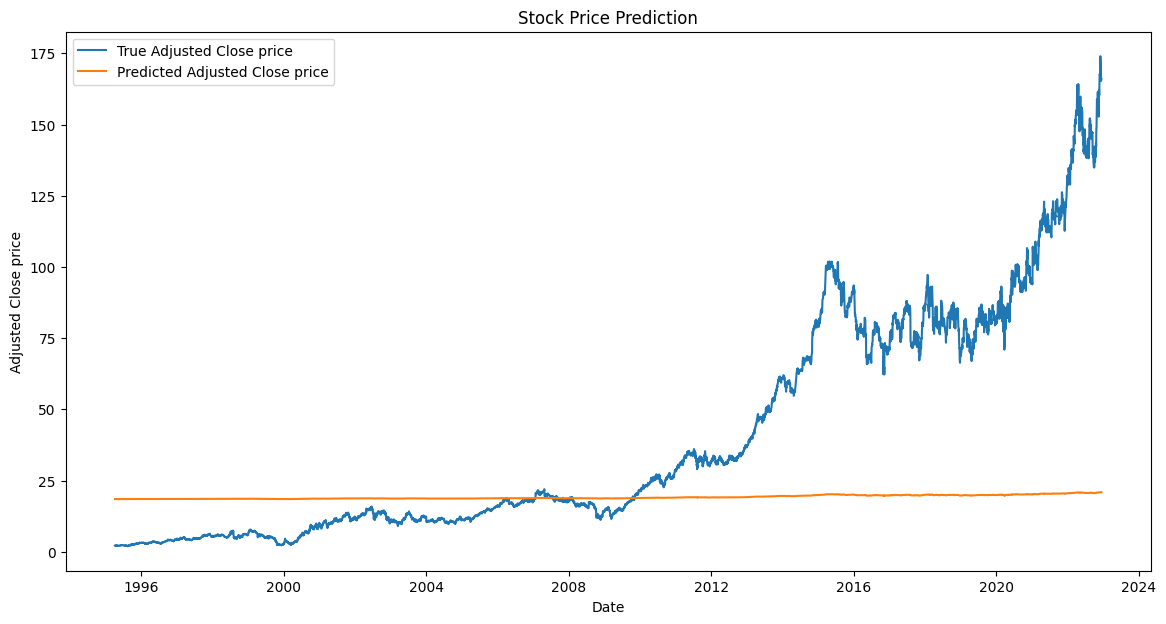

In [16]:
# Validate the model
predictions = []

# Make predictions on the entire dataset
model.eval()
with torch.no_grad():
    test_seq = torch.tensor(X, dtype=torch.float32)
    for i in range(len(test_seq)):
        # Get the prediction
        prediction = model(test_seq[i:i+1]).item()
        
        # Reshape the prediction to match the scaler's expected input format
        prediction_reshaped = np.array([[prediction]])
        
        # Reverse the normalization
        prediction_original = scaler.inverse_transform(prediction_reshaped)[0, 0]
        
        predictions.append(prediction_original)

# print("Predictions: ", predictions)



# Calculate the mean squared error
from sklearn.metrics import mean_squared_error
y_true = scaler.inverse_transform(y.reshape(-1, 1))
mse = mean_squared_error(y_true, predictions)
print("Mean Squared Error:", mse)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][1:], y_true, label='True Adjusted Close price')
plt.plot(data['Date'][1:], predictions, label='Predicted Adjusted Close price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Adjusted Close price')
plt.legend()
plt.show()

